In [154]:
# Importation des bibliothèques nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

import warnings
warnings.filterwarnings("ignore")

In [209]:
# Téléchargement des données historiques
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
benchmark_ticker = '^GSPC'  # S&P 500
start_date = "2010-01-01"
end_date = "2024-11-30"

# Téléchargement des données de clôture ajustée
data = yf.download(tickers + [benchmark_ticker], start=start_date, end=end_date)['Adj Close']
returns = data[tickers].pct_change().dropna()
sp500_returns = data[benchmark_ticker].pct_change().dropna()

# Séparation des périodes in-sample et out-of-sample
split_date = "2019-01-01"
returns_in = returns.loc[:split_date]
returns_out = returns.loc[split_date:]

[*********************100%%**********************]  6 of 6 completed


In [210]:
# Fonction Markowitz avec coûts linéaires
def markowitz_linear(returns, lin_cost, risk_target):
    n = returns.shape[1]
    mu = returns.mean().values
    Sigma = returns.cov().values
    w = cvx.Variable(n)
    portfolio_return = mu @ w
    portfolio_risk = cvx.quad_form(w, Sigma)
    transaction_cost = lin_cost @ cvx.abs(w)
    objective = cvx.Maximize(portfolio_return - transaction_cost)
    constraints = [cvx.sum(w) == 1, portfolio_risk <= risk_target**2, w >= 0]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [211]:
# Fonction Markowitz avec maximisation des rendements
def markowitz_max_return(returns):
    n = returns.shape[1]
    mu = returns.mean().values  # Rendements moyens des actifs
    # Variable d'optimisation
    w = cvx.Variable(n)
    # Fonction objectif : maximiser le rendement total
    objective = cvx.Maximize(mu @ w)
    # Contraintes : somme des poids = 1 et poids >= 0
    constraints = [
        cvx.sum(w) == 1,
        w >= 0
    ]
    # Résolution du problème d'optimisation
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [212]:
# Fonction Markowitz maximisant l'utilité
def markowitz_utility(returns, risk_aversion):
    n = returns.shape[1]
    mu = returns.mean().values
    Sigma = returns.cov().values
    w = cvx.Variable(n)
    utility = mu @ w - risk_aversion / 2 * cvx.quad_form(w, Sigma)
    constraints = [cvx.sum(w) == 1, w >= 0]
    problem = cvx.Problem(cvx.Maximize(utility), constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [213]:
# Fonction ERC
def computeERC(Sigma):
    Sigma = np.array(Sigma)
    n = np.shape(Sigma)[0]
    x0 = np.ones((n, 1)) / n
    x = x0 * 10
    var = np.diag(Sigma)
    Sx = Sigma.dot(x)
    convergence = False
    while not convergence:
        for i in range(n):
            alpha = var[i]
            beta = (Sx[i] - x[i] * var[i])[0]
            gamma_ = -1.0 / n
            x_tilde = (-beta + np.sqrt(beta**2 - 4 * alpha * gamma_)) / (2 * alpha)
            x[i] = x_tilde
            Sx = Sigma.dot(x)
        convergence = np.sum((x / np.sum(x) - x0 / np.sum(x0))**2) <= 1e-5
        x0 = x.copy()
    return (x / x.sum()).flatten()

In [214]:
# ------------------------------- HRP ------------------------------
# Fonction pour calculer la distance basée sur la corrélation
def correlDist(corr):
    """
    Calcule la matrice de distance basée sur la corrélation.
    """
    dist = ((1 - corr) / 2) ** 0.5
    return dist

# Tri quasi-diagonal pour ordonner les actifs
def getQuasiDiag(link):
    link = link.astype(int)  # Convertit les indices des clusters en entiers
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])  # Initialise avec les deux derniers indices de fusion
    numItems = link[-1, 3]  # Nombre total d'éléments avant fusion
    while sortIx.max() >= numItems:  # Tant que les indices sont des clusters (et non des éléments initiaux)
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # Double l'index pour les sous-clusters
        df0 = sortIx[sortIx >= numItems]  # Trouve les indices représentant des clusters
        i = df0.index  # Indices où les clusters apparaissent
        j = df0.values - numItems  # Récupère les indices de liaison des clusters
        sortIx[i] = link[j, 0]  # Remplace les indices par le premier sous-cluster
        df0 = pd.Series(link[j, 1], index=i + 1)  # Ajoute le second sous-cluster
        sortIx = pd.concat([sortIx, df0]).sort_index()  # Combine et trie les indices
        sortIx.index = range(sortIx.shape[0])  # Réindexe pour suivre l'ordre
    return sortIx.tolist()  # Retourne l'ordre final des indices


# Calcul de la variance par cluster
def getClusterVar(cov, cItems):
    cov_ = cov.loc[cItems, cItems]  # Extrait la sous-matrice de covariance
    ivp = 1 / np.diag(cov_)  # Calcule les poids inverses des variances diagonales
    ivp /= ivp.sum()  # Normalise les poids pour qu'ils totalisent 1
    cVar = np.dot(np.dot(ivp.T, cov_), ivp)  # Calcule la variance du cluster
    return cVar

# Allocation bipartite récursive pour HRP
def getRecBipart(cov, sortIx):
    sortIx = [cov.columns[int(i)] for i in sortIx]  # Convertit les indices en noms d'actifs
    w = pd.Series(1, index=sortIx)  # Initialise des poids égaux à 1 pour tous les actifs
    cItems = [sortIx]  # Initialise la liste des clusters avec tous les actifs
    while len(cItems) > 0:  # Tant qu'il y a des clusters à traiter
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  
        for i in range(0, len(cItems), 2):  # Parcourt les paires de clusters
            cVar0 = getClusterVar(cov, cItems[i])  # Variance du premier sous-cluster
            cVar1 = getClusterVar(cov, cItems[i + 1])  # Variance du second sous-cluster
            alpha = 1 - cVar0 / (cVar0 + cVar1)  # Ratio pour ajuster les poids
            w[cItems[i]] *= alpha  # Réduit les poids pour le premier sous-cluster
            w[cItems[i + 1]] *= 1 - alpha  # Réduit les poids pour le second sous-cluster
    return w  # Retourne les poids finaux


In [215]:

# Fonction pour afficher le dendrogramme avec la matrice de corrélation réorganisée
def plotDendrogramWithHeatmap(corr):
    """
    Affiche un dendrogramme couplé à la matrice de corrélation sous forme de heatmap.
    """
    # Étape 1 : Calcul de la distance et clustering hiérarchique
    dist = correlDist(corr)
    dist_condensed = ssd.squareform(dist)
    link = sch.linkage(dist_condensed, method='single')
    
    # Étape 2 : Création de la figure avec le dendrogramme et la heatmap
    fig = plt.figure(figsize=(20, 10))
    
    # Ajout du dendrogramme (en haut)
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.8])
    dendro = sch.dendrogram(link, orientation='left', labels=corr.columns, ax=ax1, leaf_font_size=10)
    ax1.set_title("Dendrogramme des actifs")

    # Réorganisation de la matrice de corrélation
    idx = dendro['leaves']
    corr_reordered = corr.iloc[idx, idx]

    # Ajout de la heatmap (à droite)
    ax2 = fig.add_axes([0.35, 0.1, 0.6, 0.8])
    cax = ax2.matshow(corr_reordered, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(cax, ax=ax2)
    
    ax2.set_xticks(range(len(corr.columns)))
    ax2.set_xticklabels(corr_reordered.columns, rotation=90, fontsize=10)
    ax2.set_yticks(range(len(corr.columns)))
    ax2.set_yticklabels(corr_reordered.columns, fontsize=10)
    ax2.set_title("Matrice de corrélation réorganisée")

    plt.tight_layout()
    plt.savefig("Dendrogram_Heatmap_Correlation.png")
    plt.show()

# Fonction pour afficher la matrice de corrélation sous forme de heatmap simple
def plotCorrMatrix(path, corr, labels=None):
    if labels is None:
        labels = []
    plt.figure(figsize=(20, 10))
    plt.pcolor(corr, cmap="coolwarm")
    plt.colorbar()
    plt.yticks(np.arange(0.5, corr.shape[0] + 0.5), labels)
    plt.xticks(np.arange(0.5, corr.shape[0] + 0.5), labels, rotation=90)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

# Fonction pour afficher le dendrogramme
def plotDendrogram(corr):
    """
    Affiche uniquement le dendrogramme.
    """
    dist = correlDist(corr)
    dist_condensed = ssd.squareform(dist)
    link = sch.linkage(dist_condensed, method='single')

    plt.figure(figsize=(10, 6))
    sch.dendrogram(link, labels=corr.columns, orientation='top', leaf_font_size=10)
    plt.title("Dendrogramme des actifs")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.savefig("HRP_Dendrogram.png")
    plt.show()

# Fonction pour afficher la heatmap de corrélation réorganisée
def plotReorderedHeatmap(corr):
    """
    Affiche uniquement la matrice de corrélation réorganisée.
    """
    # Étape 1 : Clustering hiérarchique
    dist = correlDist(corr)
    dist_condensed = ssd.squareform(dist)
    link = sch.linkage(dist_condensed, method='single')
    dendro = sch.dendrogram(link, no_plot=True)

    # Étape 2 : Réorganisation de la matrice
    idx = dendro['leaves']
    corr_reordered = corr.iloc[idx, idx]

    # Étape 3 : Affichage de la heatmap
    plt.figure(figsize=(20, 10))
    plt.matshow(corr_reordered, cmap='coolwarm', vmin=-1, vmax=1, fignum=1)
    plt.colorbar()
    plt.title("Matrice de corrélation réorganisée", pad=20)
    plt.xticks(range(len(corr.columns)), corr_reordered.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr_reordered.columns)
    plt.tight_layout()
    plt.savefig("HRP_Reordered_Heatmap.png")
    plt.show()

# Fonction pour afficher la matrice de corrélation simple
def plotCorrMatrix(path, corr, labels=None):
    """
    Affiche la heatmap simple de la matrice de corrélation.
    """
    if labels is None:
        labels = corr.columns
    plt.figure(figsize=(8, 6))
    plt.pcolor(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.yticks(np.arange(0.5, corr.shape[0] + 0.5), labels)
    plt.xticks(np.arange(0.5, corr.shape[0] + 0.5), labels, rotation=90)
    plt.title("Matrice de corrélation")
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

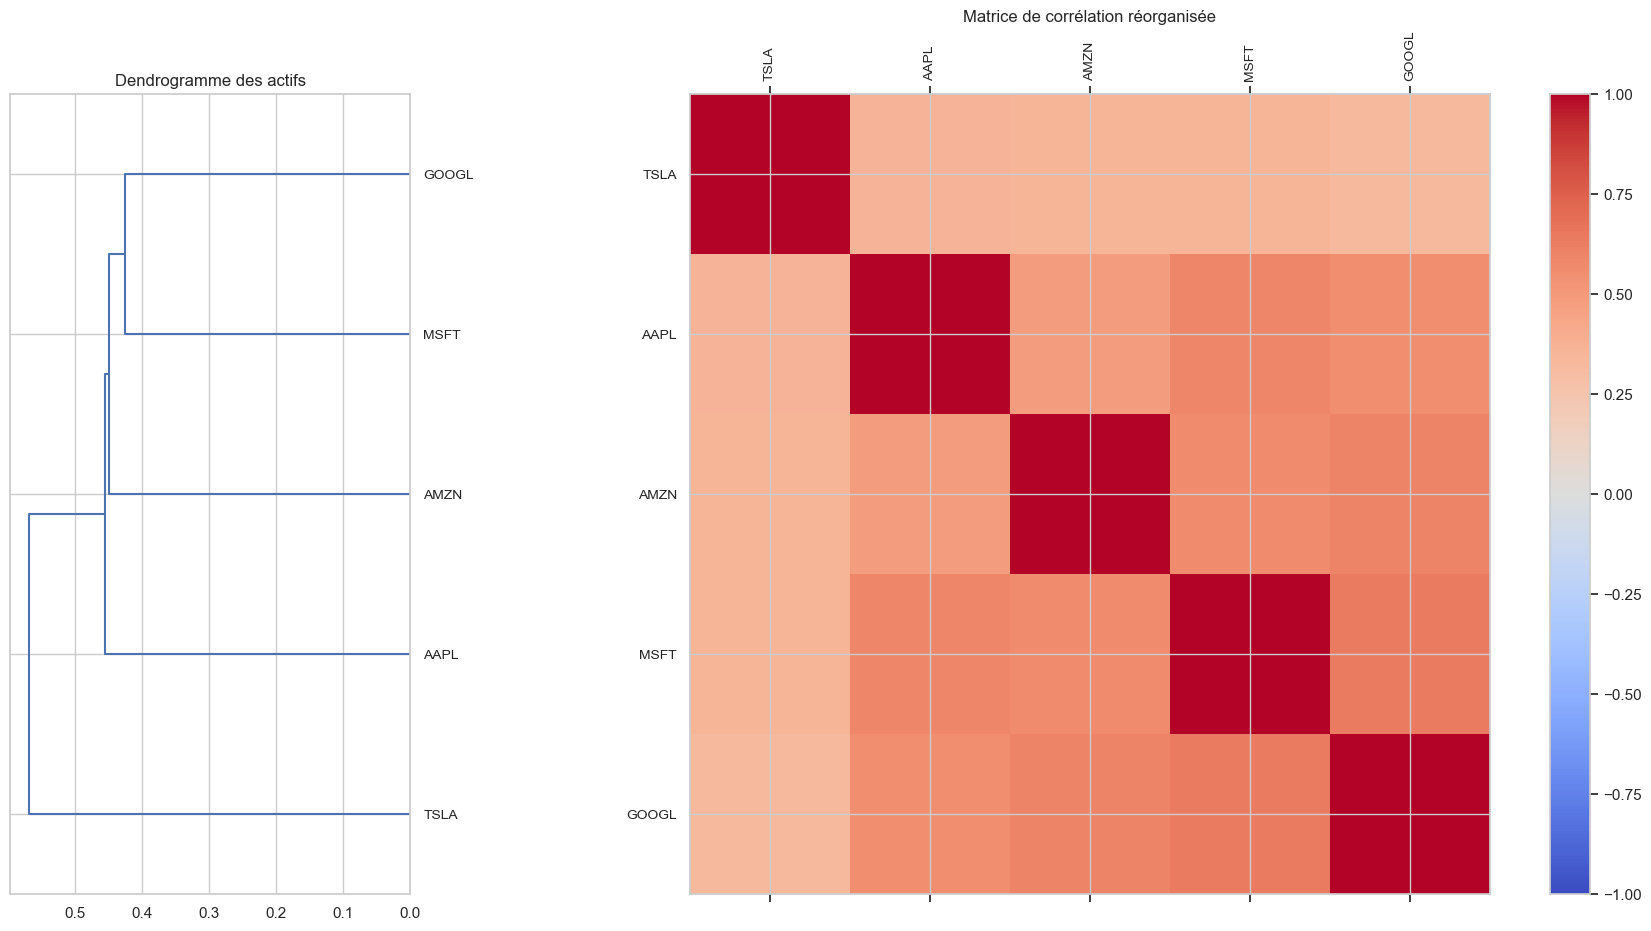


Allocation HRP :
TSLA     0.079632
AAPL     0.339209
AMZN     0.202762
MSFT     0.200707
GOOGL    0.177690
dtype: float64


In [216]:
# Calcul des matrices de corrélation et covariance
corr = returns.corr()
cov = returns.cov()

# Étape 1 : Conversion en matrice de distances condensée
dist = correlDist(corr)
dist_condensed = ssd.squareform(dist)

# Étape 2 : Clustering hiérarchique
link = sch.linkage(dist_condensed, 'single')

# Étape 3 : Affichage du dendrogramme couplé à la heatmap de corrélation
plotDendrogramWithHeatmap(corr)

# Étape 4 : Tri quasi-diagonal
sortIx = getQuasiDiag(link)

# Étape 5 : Allocation HRP
hrp = getRecBipart(cov, sortIx)
print("\nAllocation HRP :")
print(hrp)


In [217]:
# Calcul des portefeuilles in-sample
cov_in = returns_in.cov()
lin_cost = np.full(returns_in.shape[1], 0.001)  # Coût linéaire
risk_target = 0.02
risk_aversion = 5

weights_hrp = getRecBipart(cov, sortIx)
#weights_max_return = markowitz_max_return(returns_in)
weights_linear = markowitz_linear(returns_in, lin_cost, risk_target)
weights_utility = markowitz_utility(returns_in, risk_aversion)
weights_erc = computeERC(cov_in)
weights_equal = np.ones(len(tickers)) / len(tickers)

In [218]:
# Backtest out-of-sample
returns_out_cum = pd.DataFrame({
    "Markowitz Transaction Cost": (returns_out @ weights_linear).cumsum(),
    "Markowitz Utility": (returns_out @ weights_utility).cumsum(),
    "ERC": (returns_out @ weights_erc).cumsum(),
    "Equal Weight": (returns_out @ weights_equal).cumsum(),
    "HRP Weight": (returns_out @ weights_hrp).cumsum(),
    "S&P 500": sp500_returns.loc[returns_out.index].cumsum()
})

# Backtest in-sample
returns_in_cum = pd.DataFrame({
    "Markowitz Transaction Cost": (returns_in @ weights_linear).cumsum(),
    "Markowitz Utility": (returns_in @ weights_utility).cumsum(),
    "ERC": (returns_in @ weights_erc).cumsum(),
    "Equal Weight": (returns_in @ weights_equal).cumsum(),
    "HRP Weight": (returns_in @ weights_hrp).cumsum(),
    "S&P 500": sp500_returns.loc[returns_in.index].cumsum()
})

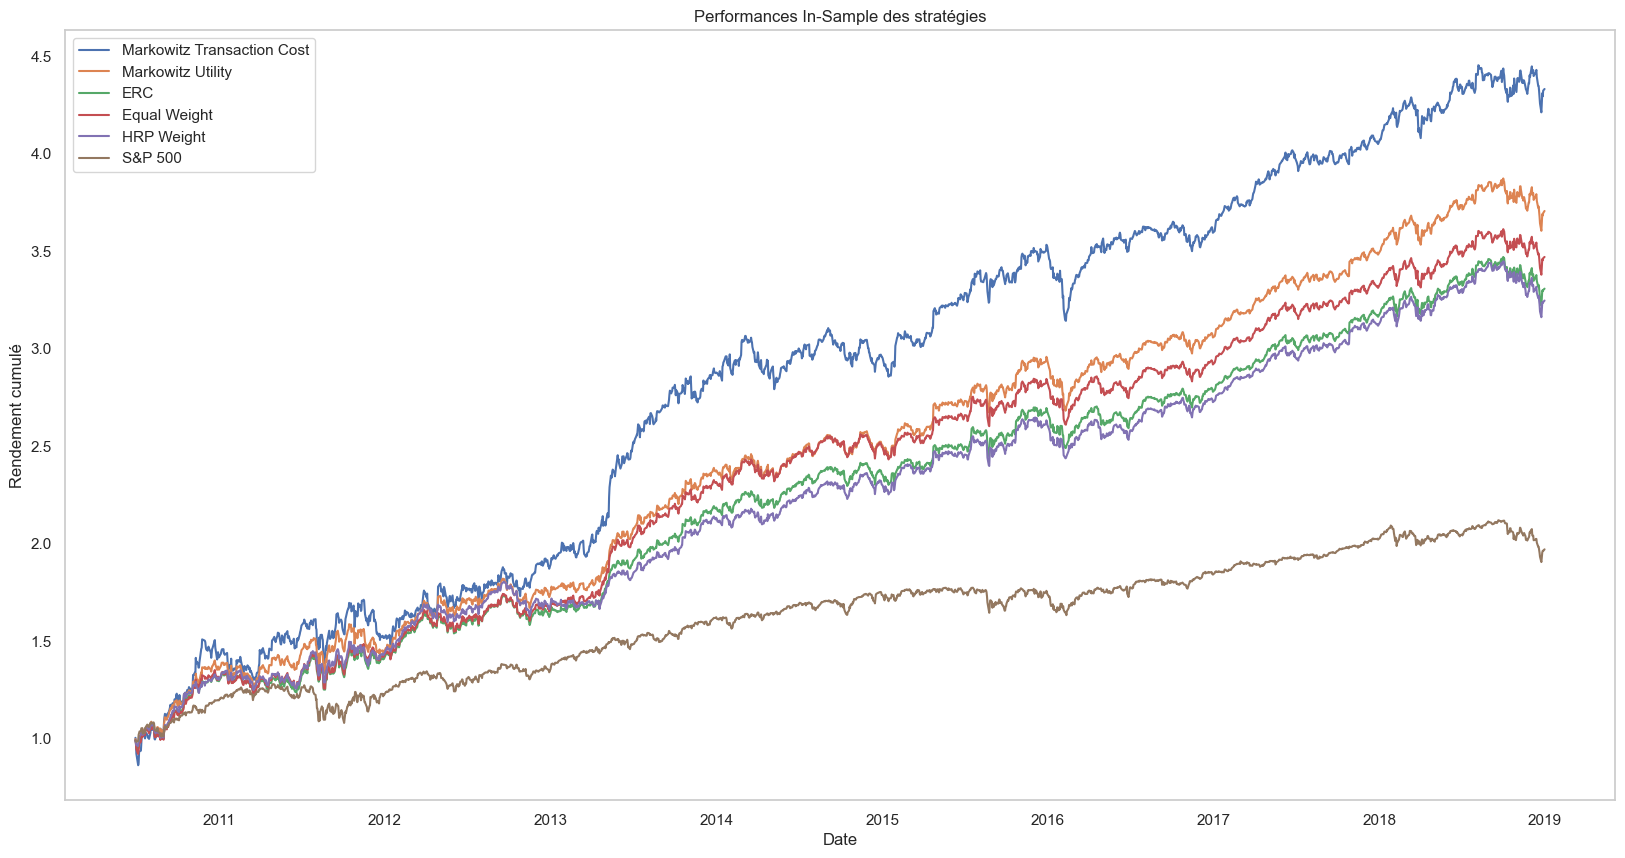

In [219]:
# Visualisation des performances In-Sample
plt.figure(figsize=(20, 10))
for col in returns_in_cum.columns:
    plt.plot(1+returns_in_cum[col], label=col)
plt.title("Performances In-Sample des stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid()
plt.show()

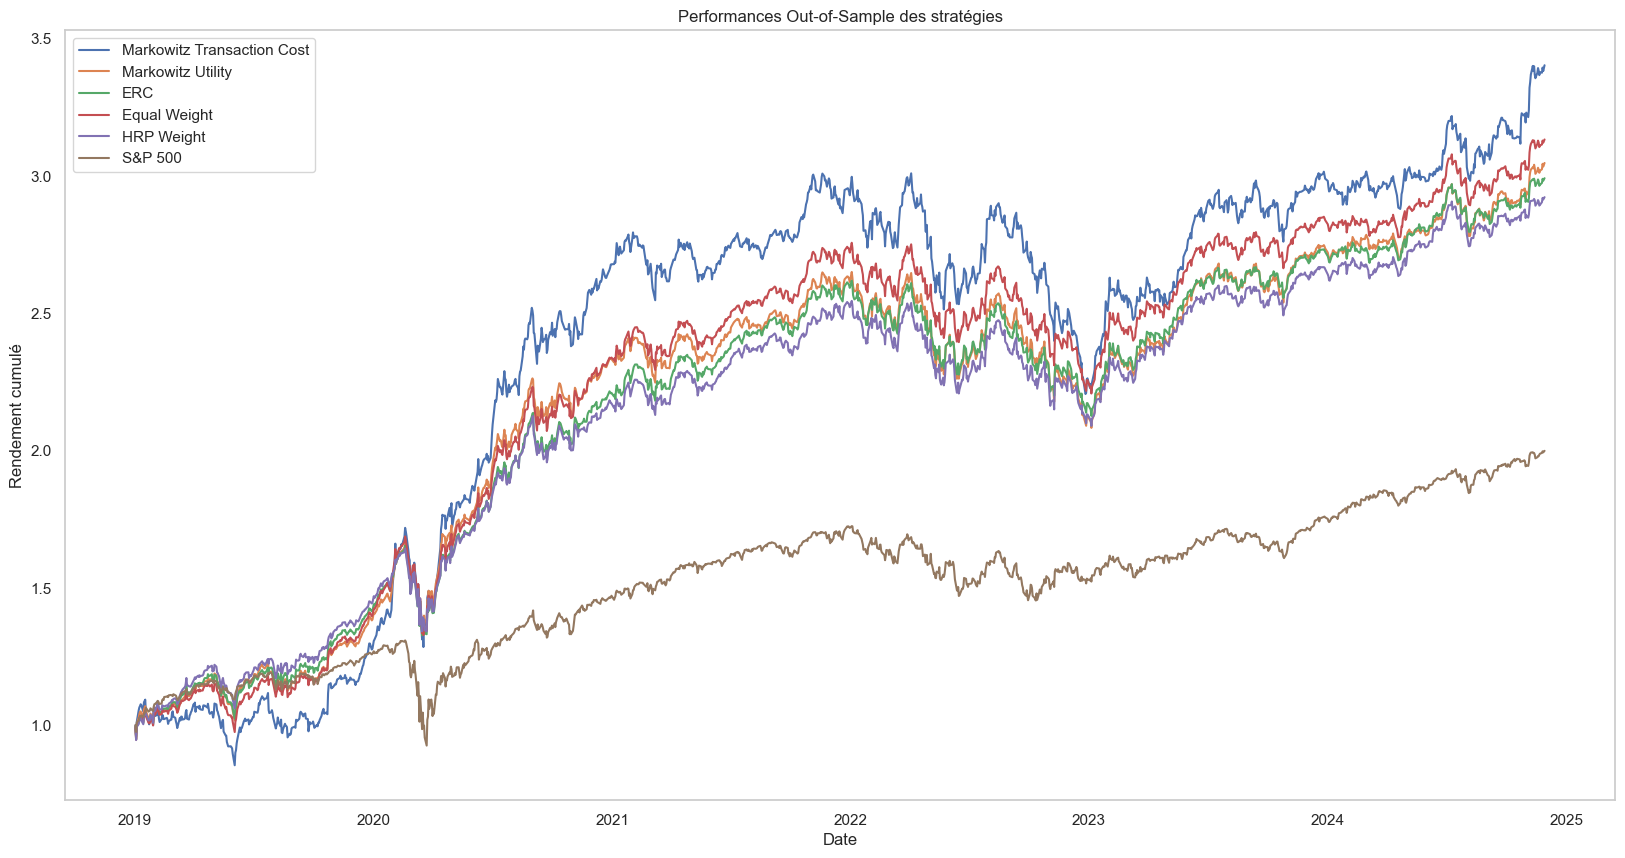

In [220]:
# Visualisation des performances Out-of-Sample
plt.figure(figsize=(20, 10))
for col in returns_out_cum.columns:
    plt.plot(1+returns_out_cum[col], label=col)
plt.title("Performances Out-of-Sample des stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid()
plt.show()

In [221]:
# Statistiques de performance
def performance_stats(returns):
    """
    Calcule les statistiques de performance :
    - Mean Return annualisé
    - Volatilité annualisée
    - Ratio de Sharpe
    - Cumulative Return
    """
    mean_return = returns.mean() * 252
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = mean_return / volatility
    cumulative_return = returns.sum()
    return {"Mean Return": mean_return, "Volatility": volatility, 
            "Sharpe Ratio": sharpe_ratio, "Cumulative Return": cumulative_return}

# Appliquer la fonction aux rendements journaliers
stats = pd.DataFrame({col: performance_stats(returns_out_cum[col].diff().dropna()) 
                      for col in returns_out_cum.columns}).T

# Afficher les statistiques
print("Statistiques de performance :")
stats


Statistiques de performance :


,Mean Return,Volatility,Sharpe Ratio,Cumulative Return
Markowitz Transaction Cost,0.408964,0.390457,1.047399,2.414834
Markowitz Utility,0.347120,0.307569,1.128591,2.049660
ERC,0.337825,0.286155,1.180564,1.994775
Equal Weight,0.362398,0.302332,1.198678,2.139876
HRP Weight,0.325470,0.279527,1.164363,1.921826
S&P 500,0.169048,0.202048,0.836675,0.998189


In [222]:
weights_linear

Ticker
AAPL     2.191121e-08
MSFT     2.310959e-08
AMZN     6.017646e-01
GOOGL    1.630904e-08
TSLA     3.982353e-01
dtype: float64

### Trend Following Strat 

In [290]:
import yfinance as yf
import pandas as pd
import numpy as np

# Téléchargement des données historiques
#tickers = ['AAPL', 'MSFT', 'AMZN','GOOGL', 'TSLA']
tickers = [
    "QQQ",    # ETF Nasdaq (standard)
    "TQQQ",   # ETF Nasdaq à effet de levier (3x)
    "TLT",    # ETF Obligataire (US Treasury Bonds 20+ ans)
    "SPY",    # ETF S&P 500
    "SMH"     # ETF Semi-conducteurs (VanEck Semiconductor ETF)
]
benchmark_ticker = '^GSPC'  # S&P 500
start_date = "2015-01-01"
end_date = "2024-11-30"

# Téléchargement des données de clôture ajustée
data = yf.download(tickers , start=start_date, end=end_date)['Adj Close']

# Mise en forme des données pour le traitement
allPrices = data.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="c")
allPrices['NextOpen'] = allPrices.groupby('Ticker')['c'].shift(-1)

# 1. Calcul des rendements logarithmiques avec transform
allPrices['Return'] = allPrices.groupby('Ticker')['c'].transform(lambda x: np.log(x).diff())
allPrices['ReturnTC'] = allPrices.groupby('Ticker')['NextOpen'].transform(lambda x: np.log(x).diff())

# 2. Calcul de la volatilité roulante (256 jours, écart-type)
rolling_window = 256
allPrices['RunVol'] = allPrices.groupby('Ticker')['Return'].transform(lambda x: x.rolling(rolling_window).std())

# 3. Normalisation des rendements
scaling_factor = 0.1
allPrices['rhat'] = allPrices['Return'] * scaling_factor / allPrices['RunVol']

# 4. Suppression des valeurs NaN issues des calculs roulants
allPrices.dropna(subset=['Return', 'RunVol', 'rhat'], inplace=True)

# Affichage des premières lignes pour vérifier
print(allPrices.head())


[*********************100%%**********************]  5 of 5 completed

          Date Ticker          c   NextOpen    Return  ReturnTC    RunVol  \
256 2016-01-08    QQQ  97.386726  97.686356 -0.008234  0.003072  0.011463   
257 2016-01-11    QQQ  97.686356  98.819290  0.003072  0.011531  0.011427   
258 2016-01-12    QQQ  98.819290  95.411102  0.011531 -0.035098  0.011416   
259 2016-01-13    QQQ  95.411102  97.442924 -0.035098  0.021072  0.011601   
260 2016-01-14    QQQ  97.442924  94.418579  0.021072 -0.031529  0.011615   

         rhat  
256 -0.071835  
257  0.026885  
258  0.101003  
259 -0.302547  
260  0.181418  


In [291]:
allPrices

,Date,Ticker,c,NextOpen,Return,ReturnTC,RunVol,rhat
256,2016-01-08,QQQ,97.386726,97.686356,-0.008234,0.003072,0.011463,-0.071835
257,2016-01-11,QQQ,97.686356,98.819290,0.003072,0.011531,0.011427,0.026885
258,2016-01-12,QQQ,98.819290,95.411102,0.011531,-0.035098,0.011416,0.101003
259,2016-01-13,QQQ,95.411102,97.442924,-0.035098,0.021072,0.011601,-0.302547
260,2016-01-14,QQQ,97.442924,94.418579,0.021072,-0.031529,0.011615,0.181418
...,...,...,...,...,...,...,...,...
12470,2024-11-22,TQQQ,78.250000,78.610001,0.003713,0.004590,0.032615,0.011384
12471,2024-11-25,TQQQ,78.610001,79.830002,0.004590,0.015400,0.032616,0.014073
12472,2024-11-26,TQQQ,79.830002,77.900002,0.015400,-0.024473,0.032561,0.047297
12473,2024-11-27,TQQQ,77.900002,79.889999,-0.024473,0.025225,0.032579,-0.075120


In [292]:
# Étape 1 : Suppression des lignes avec NaN dans la colonne 'rhat'
allPricesClean = allPrices.dropna(subset=['rhat']).copy()

# Étape 2 : Calcul des sommes cumulées groupées par 'Ticker'
allPricesClean['rhatC'] = allPricesClean.groupby('Ticker')['rhat'].cumsum()
allPricesClean['rc'] = allPricesClean.groupby('Ticker')['Return'].cumsum()

# Affichage des premières lignes
print(allPricesClean.head())

          Date Ticker          c   NextOpen    Return  ReturnTC    RunVol  \
256 2016-01-08    QQQ  97.386726  97.686356 -0.008234  0.003072  0.011463   
257 2016-01-11    QQQ  97.686356  98.819290  0.003072  0.011531  0.011427   
258 2016-01-12    QQQ  98.819290  95.411102  0.011531 -0.035098  0.011416   
259 2016-01-13    QQQ  95.411102  97.442924 -0.035098  0.021072  0.011601   
260 2016-01-14    QQQ  97.442924  94.418579  0.021072 -0.031529  0.011615   

         rhat     rhatC        rc  
256 -0.071835 -0.071835 -0.008234  
257  0.026885 -0.044950 -0.005162  
258  0.101003  0.056053  0.006368  
259 -0.302547 -0.246493 -0.028729  
260  0.181418 -0.065075 -0.007658  


In [293]:
# Regroupement par 'Ticker' et calcul des statistiques agrégées
stats = allPricesClean.groupby('Ticker').agg(
    AvgReturn=('Return', 'mean'),
    AvgNormReturn=('rhat', 'mean'),
    StdReturn=('Return', 'std'),
    StdNormReturn=('rhat', 'std')
).reset_index()

# Affichage des résultats
print(stats)

  Ticker  AvgReturn  AvgNormReturn  StdReturn  StdNormReturn
0    QQQ   0.000736       0.005704   0.014033       0.105341
1    SMH   0.001059       0.005775   0.019817       0.105159
2    SPY   0.000573       0.005728   0.011290       0.106368
3    TLT  -0.000022       0.000807   0.009643       0.102959
4   TQQQ   0.001364       0.003679   0.041974       0.105400


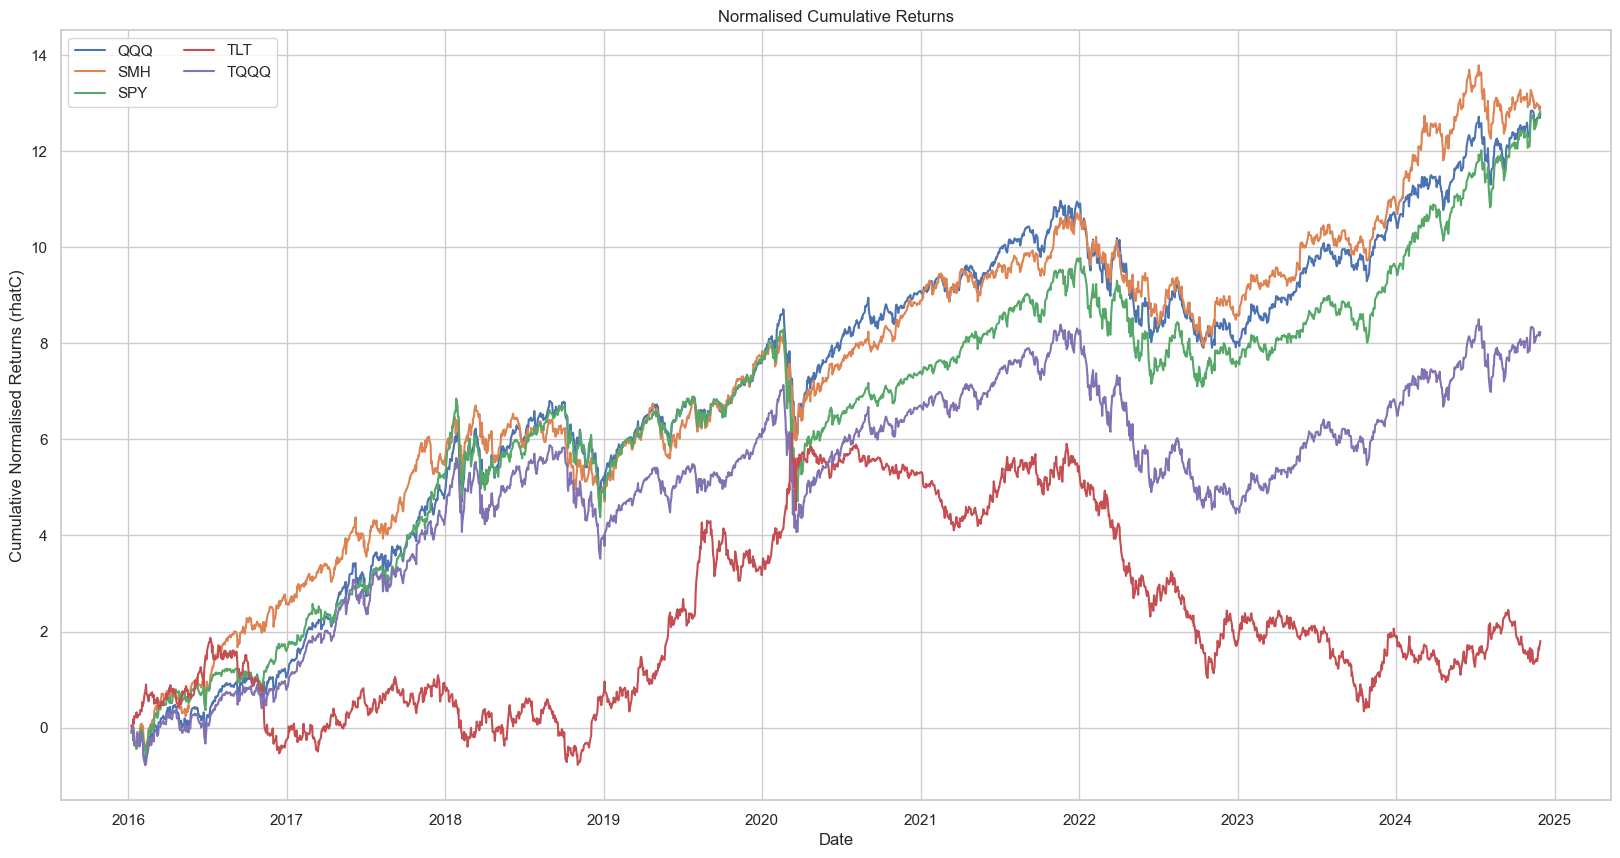

In [294]:
import seaborn as sns

# Configuration du style pour une meilleure lisibilité
sns.set(style="whitegrid")

# Création du graphique
plt.figure(figsize=(20, 10))

# Boucle pour tracer les courbes pour chaque Ticker
for ticker, data in allPricesClean.groupby('Ticker'):
    plt.plot(data['Date'], data['rhatC'], label=ticker)

# Configuration des axes et titre
plt.title("Normalised Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Normalised Returns (rhatC)")

# Placement de la légende
plt.legend(loc="upper left", ncol=2)

# Affichage du graphique
plt.show()

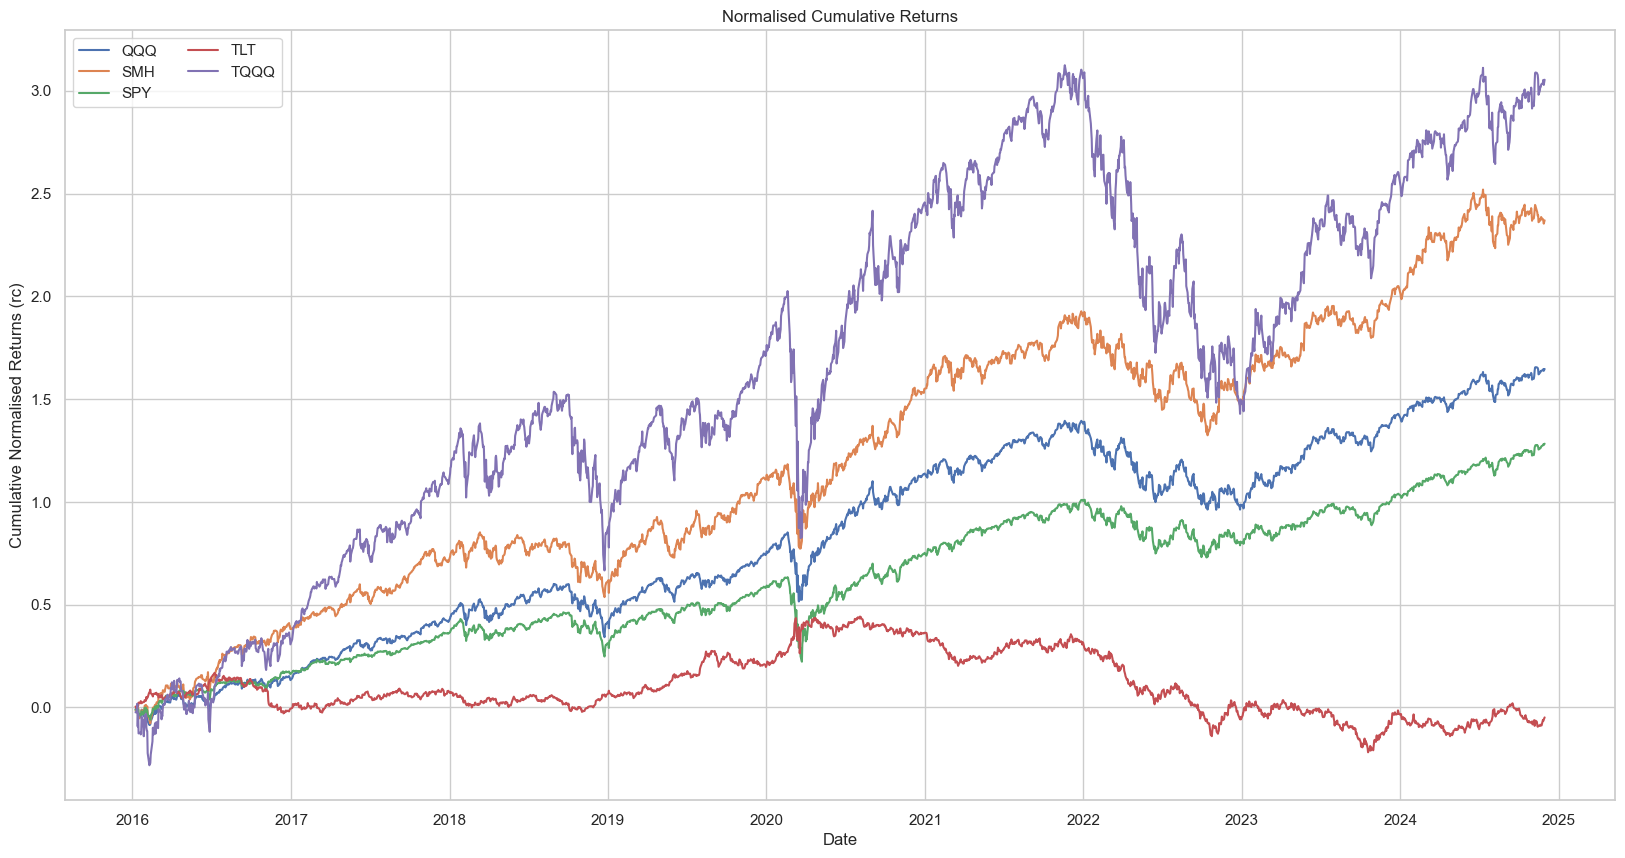

In [295]:

# Configuration du style pour une meilleure lisibilité
sns.set(style="whitegrid")

# Création du graphique
plt.figure(figsize=(20, 10))

# Boucle pour tracer les courbes pour chaque Ticker
for ticker, data in allPricesClean.groupby('Ticker'):
    plt.plot(data['Date'], data['rc'], label=ticker)

# Configuration des axes et titre
plt.title("Normalised Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Normalised Returns (rc)")

# Placement de la légende
plt.legend(loc="upper left", ncol=2)

# Affichage du graphique
plt.show()

In [378]:
# Étape 1 : Ajout des colonnes 'Signal' et 'SignalLO'
# Moyenne mobile roulante sur 100 périodes pour chaque Ticker
allPricesClean['RunMean'] = allPricesClean.groupby('Ticker')['rhat'].transform(lambda x: x.rolling(100).mean())

# Signal : signe de la moyenne mobile roulante
allPricesClean['Signal'] = np.sign(allPricesClean['RunMean'])

# SignalLO : booléen indiquant si la moyenne mobile roulante est strictement positive
allPricesClean['SignalLO'] = allPricesClean['RunMean'] > 0

# Affichage des premières lignes pour vérification
print(allPricesClean[['Date', 'Ticker', 'rhat', 'RunMean', 'Signal', 'SignalLO']].head())


          Date Ticker      rhat  RunMean  Signal  SignalLO
256 2016-01-08    QQQ -0.071835      NaN     NaN     False
257 2016-01-11    QQQ  0.026885      NaN     NaN     False
258 2016-01-12    QQQ  0.101003      NaN     NaN     False
259 2016-01-13    QQQ -0.302547      NaN     NaN     False
260 2016-01-14    QQQ  0.181418      NaN     NaN     False


In [379]:
# Décalage des signaux pour appliquer le signal au jour suivant
allPricesClean['SignalShifted'] = allPricesClean.groupby('Ticker')['Signal'].shift(1)
allPricesClean['SignalLOShifted'] = allPricesClean.groupby('Ticker')['SignalLO'].shift(1)

In [380]:
allPricesClean[['Date', 'Ticker', 'rhat', 'RunMean', 'Signal', 'SignalLO','SignalShifted','SignalLOShifted']]

,Date,Ticker,rhat,RunMean,Signal,SignalLO,SignalShifted,SignalLOShifted
256,2016-01-08,QQQ,-0.071835,NaN,NaN,False,NaN,NaN
257,2016-01-11,QQQ,0.026885,NaN,NaN,False,NaN,False
258,2016-01-12,QQQ,0.101003,NaN,NaN,False,NaN,False
259,2016-01-13,QQQ,-0.302547,NaN,NaN,False,NaN,False
260,2016-01-14,QQQ,0.181418,NaN,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...
12470,2024-11-22,TQQQ,0.011384,-0.000905,-1.0,False,-1.0,False
12471,2024-11-25,TQQQ,0.014073,-0.001789,-1.0,False,-1.0,False
12472,2024-11-26,TQQQ,0.047297,-0.001542,-1.0,False,-1.0,False
12473,2024-11-27,TQQQ,-0.075120,-0.002369,-1.0,False,-1.0,False


In [381]:
weights_erc

array([0.23244633, 0.24175135, 0.17527992, 0.22079268, 0.12972971])

In [382]:
# Étape 1 : Dictionnaire des poids par actif
poids_actifs = {
    'QQQ': 0.23244633,
    'TQQQ': 0.24175135,
    'TLT': 0.17527992,
    'SPY': 0.22079268,
    'SMH': 0.12972971
}
# Étape 2 : Ajouter une colonne "Poids" à partir du mapping
allPricesClean['Poids'] = allPricesClean['Ticker'].map(poids_actifs)

# Vérification de la colonne ajoutée
print(allPricesClean[['Date', 'Ticker', 'Poids']].head())

          Date Ticker     Poids
256 2016-01-08    QQQ  0.232446
257 2016-01-11    QQQ  0.232446
258 2016-01-12    QQQ  0.232446
259 2016-01-13    QQQ  0.232446
260 2016-01-14    QQQ  0.232446


In [383]:
allPricesClean[['Date', 'Ticker', 'Poids']]

,Date,Ticker,Poids
256,2016-01-08,QQQ,0.232446
257,2016-01-11,QQQ,0.232446
258,2016-01-12,QQQ,0.232446
259,2016-01-13,QQQ,0.232446
260,2016-01-14,QQQ,0.232446
...,...,...,...
12470,2024-11-22,TQQQ,0.241751
12471,2024-11-25,TQQQ,0.241751
12472,2024-11-26,TQQQ,0.241751
12473,2024-11-27,TQQQ,0.241751


In [384]:
# Étape 3 : Fonction personnalisée avec les poids ajoutés
def calculate_total_returns(group):
    return pd.Series({
        'TotalReturn':   (group['SignalShifted'] * group['rhat'] * group['Poids']).sum(),
        'TotalReturnLO': (group['SignalLOShifted'] * group['Return'] * group['Poids']).sum(),
        'TotalReturnTC': (group['SignalShifted'] * group['ReturnTC'] * group['Poids']).sum(),
        'TotalReturnUL': (group['SignalShifted'] * group['Return'] * group['Poids']).sum()
    })

# Étape 4 : Application de la fonction par groupe (Date)
portRes = allPricesClean.groupby('Date').apply(calculate_total_returns).reset_index()

# Affichage des résultats
print(portRes.head())

        Date  TotalReturn  TotalReturnLO  TotalReturnTC  TotalReturnUL
0 2016-01-08          0.0            0.0            0.0            0.0
1 2016-01-11          0.0            0.0            0.0            0.0
2 2016-01-12          0.0            0.0            0.0            0.0
3 2016-01-13          0.0            0.0            0.0            0.0
4 2016-01-14          0.0            0.0            0.0            0.0


In [385]:
# Fonction personnalisée pour calculer les rendements totaux avec signaux décalés
def calculate_total_returns(group):
    return pd.Series({
        'TotalReturnEW':   (1/5) * (group['SignalShifted'] * group['rhat']).sum(),
        'TotalReturnLOEW': (1/5) * (group['SignalLOShifted'] * group['Return']).sum(),
        'TotalReturnTCEW': (1/5) * (group['SignalShifted'] * group['ReturnTC']).sum(),
        'TotalReturnULEW': (1/5) * (group['SignalShifted'] * group['Return']).sum()
    })

# Application de la fonction par groupe (Date)
portResEW = allPricesClean.groupby('Date').apply(calculate_total_returns).reset_index()

# Affichage des premières lignes
print(portResEW.head())


        Date  TotalReturnEW  TotalReturnLOEW  TotalReturnTCEW  TotalReturnULEW
0 2016-01-08            0.0              0.0              0.0              0.0
1 2016-01-11            0.0              0.0              0.0              0.0
2 2016-01-12            0.0              0.0              0.0              0.0
3 2016-01-13            0.0              0.0              0.0              0.0
4 2016-01-14            0.0              0.0              0.0              0.0


In [386]:
portRes

,Date,TotalReturn,TotalReturnLO,TotalReturnTC,TotalReturnUL
0,2016-01-08,0.000000,0.000000,0.000000,0.000000
1,2016-01-11,0.000000,0.000000,0.000000,0.000000
2,2016-01-12,0.000000,0.000000,0.000000,0.000000
3,2016-01-13,0.000000,0.000000,0.000000,0.000000
4,2016-01-14,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2234,2024-11-22,0.014325,0.001153,0.004995,0.001038
2235,2024-11-25,-0.035743,0.001115,0.000551,-0.003964
2236,2024-11-26,0.013392,0.001713,0.006334,-0.000812
2237,2024-11-27,0.013333,-0.001297,-0.002993,0.006334


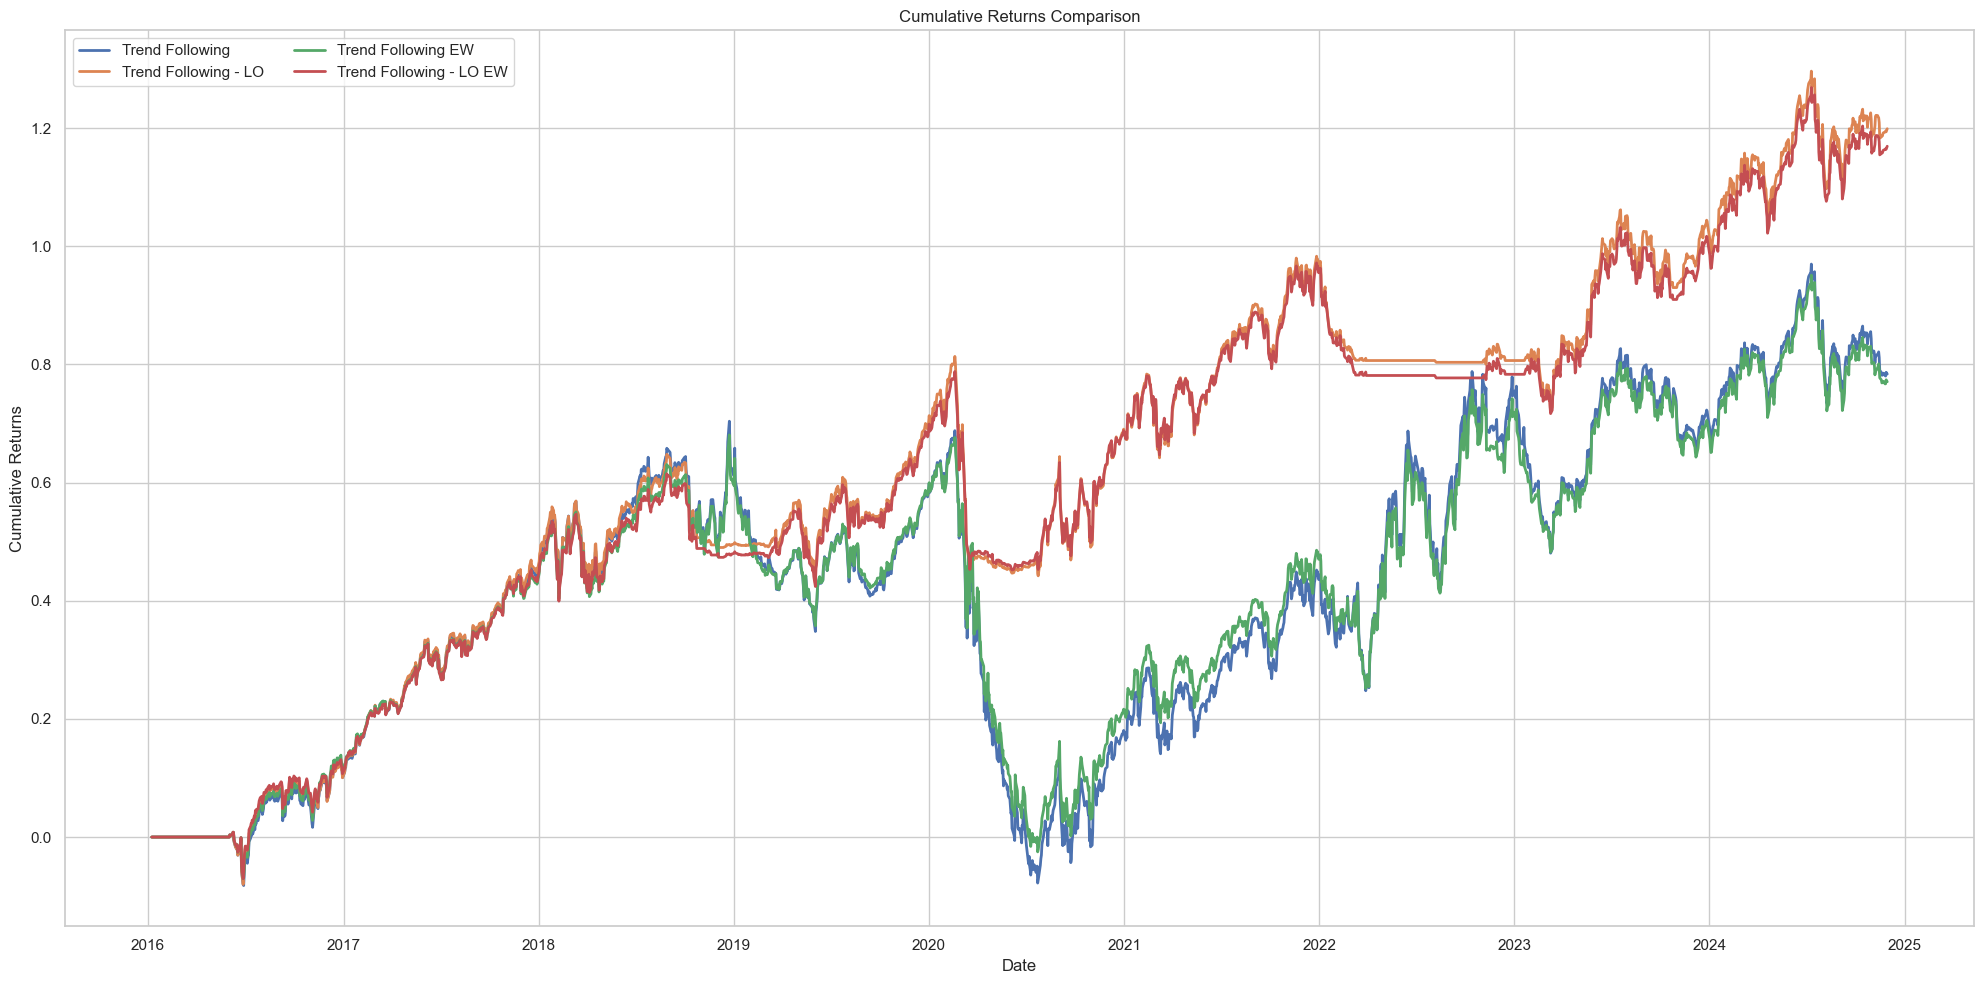

In [387]:
# Étape 1 : Calcul des sommes cumulées
portRes['TotalReturnC'] = portRes['TotalReturn'].cumsum()
portRes['TotalReturnLOC'] = portRes['TotalReturnLO'].cumsum()
portRes['TotalReturnTCC'] = portRes['TotalReturnTC'].cumsum()
portRes['TotalReturnULC'] = portRes['TotalReturnUL'].cumsum()


portResEW['TotalReturnC-EW'] = portResEW['TotalReturnEW'].cumsum()
portResEW['TotalReturnLOC-EW'] = portResEW['TotalReturnLOEW'].cumsum()
portResEW['TotalReturnTCC-EW'] = portResEW['TotalReturnTCEW'].cumsum()
portResEW['TotalReturnULC-EW'] = portResEW['TotalReturnULEW'].cumsum()

# Étape 2 : Tracer les courbes des rendements cumulés
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")

# Courbes de portRes
plt.plot(portRes['Date'], portRes['TotalReturnULC'], label="Trend Following", linewidth=2)
plt.plot(portRes['Date'], portRes['TotalReturnLOC'], label="Trend Following - LO", linewidth=2)
plt.plot(portResEW['Date'], portResEW['TotalReturnULC-EW'], label="Trend Following EW", linewidth=2)
plt.plot(portResEW['Date'], portResEW['TotalReturnLOC-EW'], label="Trend Following - LO EW", linewidth=2)

# Courbes de allPricesClean (groupé par Ticker)
#for ticker, data in allPricesClean.groupby('Ticker'):
#    plt.plot(data['Date'], data['rhatC'], label=f"Ticker: {ticker}", alpha=0.6)

# Configuration des axes et de la légende
plt.title("Cumulative Returns Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left", ncol=2)
plt.tight_layout()

# Affichage du graphique
plt.show()

In [377]:
performance_stats(portRes['TotalReturnLO'])

{'Mean Return': 0.09812619330242332,
 'Volatility': 0.2008815345765894,
 'Sharpe Ratio': 0.48847791564939036,
 'Cumulative Return': 0.871843439698912}

In [272]:
portRes['TotalReturn']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
2234    0.012990
2235    0.060838
2236    0.100863
2237   -0.038959
2238    0.039856
Name: TotalReturn, Length: 2239, dtype: float64